<a href="https://colab.research.google.com/github/anshulp2912/Named-Entity-Recognition-Guide/blob/master/NER_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>NAMED ENTITY RECOGNITION (NER)</center>

***
<font color=red><h1>INTRODUCTION</h1></font>
<br>

<font color=orange><h3>Named-entity recognition (NER)</h3></font>
Also known as entity identification, entity chunking and entity extraction is a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.
<br>

<font color=orange><h3>Why use LSTM?</h3></font>
NER problem considers that the text is a sequential data format. So, within the Deep Learning Domain, LSTM are well equipped for the task at hand. However, we use a special case of LSTM i.e. Bi-directional LSTMs because using a standard LSTM to make predictions will only take the “past” information in a sequence of the text into account. For NER, since the context covers past and future labels in a sequence, we need to take both the past and the future information into account.
<br>A bidirectional LSTM is a combination of two LSTMs — one runs forward from “right to left” and one runs backward from “left to right”.

<font color=red><h3>IMPORTING LIBRARIES AND PREPROCESSING DATASET</h3></font>

In [ ]:
# Import Libraries
!pip install livelossplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Load the dataset
dataset = pd.read_csv('ner_dataset.csv',encoding='latin1')
dataset = dataset.fillna(method='ffill')
dataset.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
# List of unique words
words = list(set(dataset['Word'].values))
words.append('ENDPAD') #to accomodate padding word
num_words = len(words)

In [ ]:
# List of unique tags
tags = list(set(dataset["Tag"].values))
num_tags = len(tags)

In [ ]:
#Preprocess Dataset
class SentenceGetter(object):
    def __init__(self, dataset):
        # Initialize of count of sentences
        self.n_sent = 1
        # Load dataset
        self.dataset = dataset
        self.empty = False
        # Create list tuples of (word,pos,tag)
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        # Group data by its Sentence number
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        # Extract Sentences
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
# Intialize object for SentenceGetter class
getter = SentenceGetter(dataset)
# Get all sentences
sentences = getter.sentences

In [ ]:
# Print a sentence
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

<font color=red><h3>MAP SENTENCES w.r.t. TAGS</h3></font>

In [ ]:
# Assign a number to each unique word in the dictionary
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
word2idx

{'bottles': 1,
 'escalating': 2,
 'retractable': 3,
 'inseparable': 4,
 'Kareem': 5,
 'compact': 6,
 'Bombings': 7,
 '6-hour': 8,
 'discrimination': 9,
 'Mekdad': 10,
 'formal': 11,
 'flame-throwers': 12,
 'Rashid': 13,
 'crumbling': 14,
 'conspiring': 15,
 'mortgage-backed': 16,
 'one-to-one': 17,
 'Immediately': 18,
 'celestial': 19,
 '1.9': 20,
 'democracies': 21,
 'Yekiti': 22,
 'cartels': 23,
 'Franks': 24,
 'Pozarevac': 25,
 'Blame': 26,
 'intercourse': 27,
 'Waxman': 28,
 'Kanagawa': 29,
 'Nineva': 30,
 'Nigerla': 31,
 'elections': 32,
 'Paula': 33,
 'Chigwedere': 34,
 'feast': 35,
 'Innovative': 36,
 'Dudley': 37,
 'Looking': 38,
 'grown': 39,
 '1717': 40,
 'debt-restructuring': 41,
 '8,40,000': 42,
 '6.7': 43,
 'Cheema': 44,
 '35.2': 45,
 'somber': 46,
 'loaned': 47,
 'investigators': 48,
 'Louis': 49,
 'disrepair': 50,
 'court-ordered': 51,
 'Jibla': 52,
 'Hurriyet': 53,
 'ads': 54,
 'infant': 55,
 'Rompuy': 56,
 'Todd': 57,
 'Wilson': 58,
 'Esperon': 59,
 'Tian': 60,
 'Merle

In [ ]:
tag2idx

{'B-geo': 0,
 'I-tim': 1,
 'I-eve': 2,
 'I-gpe': 3,
 'I-per': 4,
 'B-eve': 5,
 'I-org': 6,
 'O': 7,
 'B-tim': 8,
 'B-art': 9,
 'I-art': 10,
 'B-nat': 11,
 'I-nat': 12,
 'B-org': 13,
 'B-gpe': 14,
 'I-geo': 15,
 'B-per': 16}

In [ ]:
# Set the maximum length of sentence
max_len = 50

# Create input data : X
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

# Create target data : y
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
# Create Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

<font color=red><h3>DEFINE Bi-LSTM MODEL</h3></font>

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

W0824 01:04:45.480205 16828 deprecation.py:506] From C:\Users\Anshul\Anaconda3\envs\ans\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0824 01:04:45.560186 16828 deprecation.py:506] From C:\Users\Anshul\Anaconda3\envs\ans\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0824 01:04:45.560186 16828 deprecation.py:506] From C:\Users\Anshul\Anaconda3\envs\ans\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.pyt

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the Model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

<font color=red><h3>TRAIN THE MODEL</h3></font>

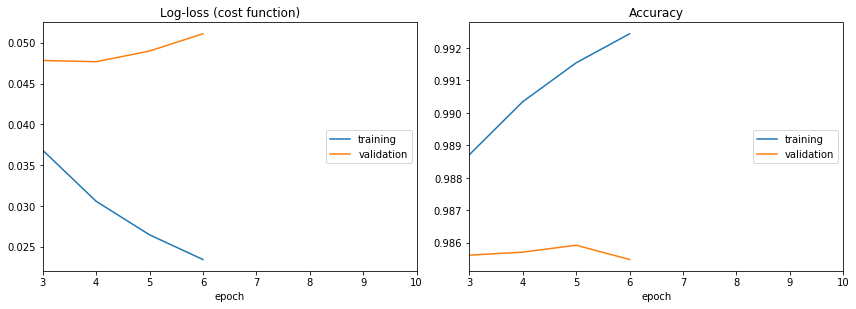

Log-loss (cost function):
training   (min:    0.023, max:    0.182, cur:    0.023)
validation (min:    0.048, max:    0.067, cur:    0.051)

Accuracy:
training   (min:    0.958, max:    0.992, cur:    0.992)
validation (min:    0.981, max:    0.986, cur:    0.985)

Epoch 00006: val_loss did not improve from 0.04767
38367/38367 [==============================] - 162s 4ms/sample - loss: 0.0234 - acc: 0.9924 - val_loss: 0.0511 - val_acc: 0.9855


In [ ]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]
# Fit Model on Training Data and validate on Test Data
history = model.fit(
    x=x_train,
    y=np.array(y_train),
    validation_data=(x_test,np.array(y_test)),
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

<font color=red><h3>EVALUATE THE MODEL ON TEST DATA</h3></font>

In [ ]:
model.evaluate(x_test, np.array(y_test))

9592/9592 [==============================] - 7s 692us/sample - loss: 0.0511 - acc: 0.9855


[0.05109790286314895, 0.98548377]

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)

for (w, t, pred) in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[t], tags[pred]))

Word           True 	Pred

------------------------------
The            O	O
Saudi          B-org	B-org
Embassy        I-org	I-org
in             O	O
Washington     B-geo	B-geo
has            O	O
not            O	O
commented      O	O
on             O	O
the            O	O
proposed       O	O
legislation    O	O
.              O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607           O	O
1607  

<font color=red><h3>SAVE THE MODEL</h3></font>

In [ ]:
model.save('ner_lstm.h5')

with open('NERobjs.pkl', 'wb') as f: 
    pickle.dump([word2idx, words, tags], f)

<font color=red><h3>LOAD THE MODEL</h3></font>

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/My Drive/NER/ner_lstm.h5")

with open('/content/drive/My Drive/NER/NERobjs.pkl','rb') as f:  
    word2idx, words, tags = pickle.load(f)

<font color=red><h3>USER INPUT PREDICTION</h3></font>

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
def make_prediction(sentence):
    sentence = re.sub('[^a-zA-Z0-9]',' ', sentence)
    tokens = word_tokenize(sentence)
    max_len = 50
    num_words = 35179
    X_pred = [[word2idx[w] for w in tokens]]
    X_pred = pad_sequences(maxlen=max_len, sequences=X_pred, padding="post", value=num_words-1)
    p = model.predict(np.array([X_pred[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}\t{}\n".format("Word", "Pred"))
    print("-"*30)
    tags_pred = []
    token_list =[]
    for (w, pred) in zip(X_pred[0][:len(tokens)], p[0][:len(tokens)]):
        print("{:15}\t{}".format(words[w-1], tags[pred]))
        tags_pred.append(tags[pred])
        tags_pred.append('O')
        token_list.append(words[w-1])
        token_list.append(' ')
        
    output_tuple = list(zip(token_list[:-1], tags_pred[:-1]))
    return output_tuple


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<font color=red><h3>EXAMPLE</h3></font>

In [ ]:
X_pred = make_prediction('John live in USA.')
X_pred

Word           	Pred

------------------------------
John           	B-per
live           	O
in             	O
USA            	B-org


[('John', 'B-per'),
 (' ', 'O'),
 ('live', 'O'),
 (' ', 'O'),
 ('in', 'O'),
 (' ', 'O'),
 ('USA', 'B-org')]

<font color=red><h3>UI for Testing using Gradio</h3></font>

In [ ]:
colormap = {'B-geo': 'magenta',
 'I-tim': 'blue',
 'I-eve': 'green',
 'I-gpe': 'yellow',
 'I-per': 'pink',
 'B-eve': 'orange',
 'I-org': 'violet',
 'O': 'white',
 'B-tim': 'indigo',
 'B-art': 'brown',
 'I-art': 'purple',
 'B-nat': 'red'}
colormap

{'B-art': 'brown',
 'B-eve': 'orange',
 'B-geo': 'magenta',
 'B-nat': 'red',
 'B-tim': 'indigo',
 'I-art': 'purple',
 'I-eve': 'green',
 'I-gpe': 'yellow',
 'I-org': 'violet',
 'I-per': 'pink',
 'I-tim': 'blue',
 'O': 'white'}

In [ ]:
!pip install gradio
import gradio as gr

     |████████████████████████████████| 983kB 2.7MB/s 
     |████████████████████████████████| 215kB 47.6MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 962kB 37.9MB/s 
     |████████████████████████████████| 2.7MB 41.8MB/s 


In [ ]:
input = gr.inputs.Textbox(lines=5, label="Text Input", placeholder="Enter a sentence that adheres to American Names and Terminology as a constraint to Dataset")
output = gr.outputs.HighlightedText(color_map=colormap, label="NER Bi-LSTM Output")
gr.Interface(make_prediction, inputs=input, outputs=output,allow_flagging=False, title='NER using Bi-LSTM', description='Created by Anshul Patel & Megh Patel. For more info, check out github.com/anshulp2912/Named-Entity-Recognition-Guide').launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on External URL: https://13777.gradio.app
Interface loading below...


(<gradio.networking.serve_files_in_background.<locals>.HTTPServer at 0x7fe7f39d6ef0>,
 'http://127.0.0.1:7860/',
 'https://13777.gradio.app')